In [34]:
import os, json
import pandas as pd
from os import path
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import decimal as d
import math as mt
import random

# Processing the Sensor Data

In this portion of the project we will load and observe the sensing data collected in our study

In [36]:
path =  os.getcwd() + '/sensing_data/'
path

'/Users/mark/Desktop/GitHub/Modeling-Student-Stress/code/sensing_data/'

In [37]:
files = os.listdir(path)[2:]
files

['activity', 'audio', 'conversation', 'gps']

In [38]:
uids = np.array(['00', '01', '02', '03', '04', '05', '07', '08', '09', '10', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24',
       '25', '27', '30', '31', '32', '33', '34', '35', '36', '39', '41',
       '42', '43', '44', '45', '46', '47', '49', '50', '51', '52', '53',
       '54', '56', '57', '58', '59'])

In [39]:
def folder_to_df(name_of_folder):

    # this finds our json files
    path_to_csv = path + name_of_folder
    csv_files = [csv for csv in os.listdir(path_to_csv) if csv.endswith('.csv')]
    
    #instantiate array for each student's responses
    responses = pd.DataFrame()
    
    # we need both the csv and an index number so use enumerate()
    for index, file_name in enumerate(csv_files):
        
        file_path = path_to_csv + '/' + file_name
        user_df = pd.read_csv(file_path)
        
        #set index to user's id and reset index
        user_df['uid'] = uids[index]
        user_df.set_index('uid', inplace = True)
        user_df.reset_index(inplace = True)
        
        responses = responses.append(user_df, sort = False)
        
    # return array of responses
    return responses

In [98]:
%%time
act_df = folder_to_df('activity')
act_df.head()

CPU times: user 41.2 s, sys: 12.9 s, total: 54.1 s
Wall time: 35.3 s


In [41]:
%%time
aud_df = folder_to_df('audio')
aud_df.head()

CPU times: user 2min 24s, sys: 1min 44s, total: 4min 8s
Wall time: 3min 29s


In [42]:
%%time
con_df = folder_to_df('conversation')
con_df.head()

CPU times: user 329 ms, sys: 224 ms, total: 553 ms
Wall time: 879 ms


In [43]:
%%time
gps_df = folder_to_df('gps')
gps_df.head()

CPU times: user 5.06 s, sys: 786 ms, total: 5.85 s
Wall time: 3.18 s


Great, lets dig into each of these data sets.

### Activity Data
- infered physical activity based on sensors in mobile device
- values includes 0: stationary, 1: walking 2: running, 3: Unknown

In [99]:
act_df.head()

,uid,timestamp,activity inference
0,00,1364356801,0
1,00,1364356804,0
2,00,1364356807,0
3,00,1364356809,0
4,00,1364356992,0


In [100]:
len(act_df)

22842191

In [101]:
act_df.head()

,uid,timestamp,activity inference
0,00,1364356801,0
1,00,1364356804,0
2,00,1364356807,0
3,00,1364356809,0
4,00,1364356992,0


Converting unix time stamp to datetime

In [102]:
act_df['time'] = pd.to_datetime(act_df['timestamp'], unit = 's')
act_df.drop(labels = ['timestamp'], axis = 1, inplace = True)
act_df.head()

,uid,activity inference,time
0,00,0,2013-03-27 04:00:01
1,00,0,2013-03-27 04:00:04
2,00,0,2013-03-27 04:00:07
3,00,0,2013-03-27 04:00:09
4,00,0,2013-03-27 04:03:12


Let us observe the overall distribution of activity during the day

Adding extra time features:
- Date
- Hour
- Day of week

In [108]:
act_df['date'] = act_df['time'].dt.date
act_df['weekday'] = act_df['time'].dt.dayofweek
act_df['hour'] = act_df['time'].dt.hour

In [110]:
act_copy = pd.DataFrame.copy(act_df)
act_copy[' activity inference'] = act_copy[' activity inference'].astype('category')

In [114]:
one_hot = pd.get_dummies(act_df,  columns = [' activity inference'])
one_hot.columns = ['uid', 'time', 'date', 'weekday', 'hour', 
                   'stationary', 'walking', 'running', 'other']
one_hot.head()

,uid,time,date,weekday,hour,stationary,walking,running,other
0,00,2013-03-27 04:00:01,2013-03-27,2,4,1,0,0,0
1,00,2013-03-27 04:00:04,2013-03-27,2,4,1,0,0,0
2,00,2013-03-27 04:00:07,2013-03-27,2,4,1,0,0,0
3,00,2013-03-27 04:00:09,2013-03-27,2,4,1,0,0,0
4,00,2013-03-27 04:03:12,2013-03-27,2,4,1,0,0,0


In [115]:
by_hour = one_hot.groupby('hour').mean()
by_hour.head()

,weekday,stationary,walking,running,other
hour,,,,,
0,2.951508,0.886477,0.063982,0.013442,0.036100
1,2.942762,0.909202,0.050792,0.008821,0.031185
2,2.966288,0.927846,0.038851,0.007921,0.025382
3,2.970834,0.929566,0.040089,0.006663,0.023682
4,2.923675,0.936669,0.035247,0.005686,0.022397


<Figure size 720x720 with 0 Axes>

Text(0.5,1,'Proportion of physical Activity by Hour of Day')

Text(0,0.5,'Proportion of activity')

([<matplotlib.axis.XTick at 0x1c837054a8>,
 <a list of 25 Text xticklabel objects>)

Text(0.5,0,'Hour')

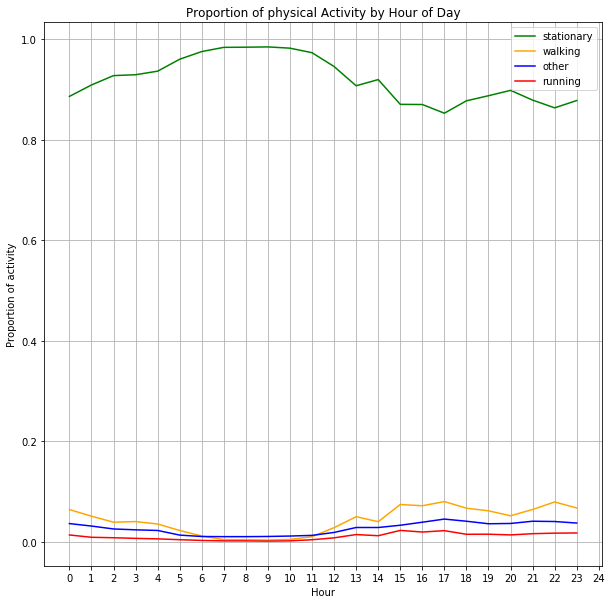

In [144]:
x = by_hour.index.values
y1 = by_hour.iloc[:,1]
y2 = by_hour.iloc[:,2]
y3 = by_hour.iloc[:,3]
y4 = by_hour.iloc[:,4]

plt.figure(figsize=(10, 10))
plot1 = sns.lineplot(x,y1, color = 'g', label = 'stationary')
plot2 = sns.lineplot(x,y2, color = 'orange', label = 'walking')
plot4 = sns.lineplot(x,y4, color = 'blue', label = 'other')
plot3 = sns.lineplot(x,y3, color = 'red', label = 'running')
plt.title('Proportion of physical Activity by Hour of Day')
plt.legend()
plt.ylabel('Proportion of activity')
plt.xticks(np.arange(0, 25, 1))
plt.xlabel('Hour')
plt.grid()
plt.show()

Seems for most the day the students are stationary, which makes sense given sleep, attending lectures, eating, and studying. Lets find out what times students are the most active.

Which hour of the day are students most active on average?

In [150]:
by_hour_act = act_df.groupby('hour').mean()

<Figure size 720x360 with 0 Axes>

([<matplotlib.axis.XTick at 0x1c83f6fbe0>,
 <a list of 25 Text xticklabel objects>)

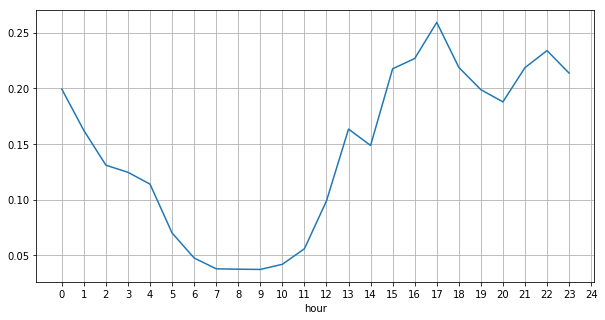

In [152]:
plt.figure(figsize=(10, 5))
y = by_hour_act.iloc[:,0].values
plot_hour = sns.lineplot(by_hour_act.index,y, )
plt.xticks(np.arange(0, 25, step=1))
plt.grid()
plt.show()

Interesting, average physical activity seems to peak around 5pm, dips around 8pm, and then hits a smaller peak around 10pm. We notice a minimum of average activity around 8am, which may be explained by sleep schedules, although 8am seems a bit late.